# 01.- General Analysis: Establishing the Foundations for Feature Engineering

In this notebook, we lay the groundwork for feature engineering by performing a general analysis of the data, which will serve as the cornerstone for creating meaningful features later in the process. The key components of this initial analysis are the use of Polyfit and the identification of local maxima and minima. These methods allow us to capture important patterns in the data that are crucial for detecting specific market behaviors, such as the "double bottom" pattern.

The goal of this step is understanding the underlying structure of data and to derive insights that can inform subsequent feature extraction. Polyfit, in particular, smooths the data and helps highlight turning points in trends, while detecting local extrema (maxima and minima) provides valuable information about price reversals or periods of consolidation.

In [1]:
import pandas as pd
import numpy as np
import pickle as pkl

from utils.plotting import candlestick_plot, local_maxima_minima_plot

## Raw Data Loading

In [2]:
# Open the pickle file containing raw benchmark data.
with open('../data/raw/benchmark_data.pkl', 'rb') as handle:
    bm = pkl.load(handle)

data = bm['ibex']
data.head()

,close,high,low,open,vol
2000-01-03,11610.0,11881.8,11574.4,11846.6,60107000.0
2000-01-04,11206.6,11530.0,11159.8,11499.5,62539000.0
2000-01-05,10863.1,11068.1,10824.9,11206.6,68153000.0
2000-01-07,11102.4,11137.9,10882.7,10963.4,144207000.0
2000-01-10,11173.3,11364.3,11120.6,11363.8,133817000.0


In [3]:
candlestick_plot(data, 'All Data')

FigureWidget({
    'data': [{'close': [11610.0, 11206.6, 10863.1, ..., 9169.2, 9236.1, 9294.1],
              'high': [11881.8, 11530.0, 11068.1, ..., 9246.2, 9261.4, 9302.2],
              'low': [11574.4, 11159.8, 10824.9, ..., 9136.7, 9185.7, 9248.1],
              'open': [11846.6, 11499.5, 11206.6, ..., 9169.2, 9186.7, 9284.2],
              'type': 'candlestick',
              'uid': 'b9a76eb4-cae8-4164-aa86-257989e92c6c',
              'x': [2000-01-03 00:00:00, 2000-01-04 00:00:00, 2000-01-05 00:00:00,
                    ..., 2019-06-06 00:00:00, 2019-06-07 00:00:00, 2019-06-10
                    00:00:00]}],
    'layout': {'height': 500,
               'template': '...',
               'title': {'text': 'Candlestick Chart: All Data'},
               'xaxis': {'rangeslider': {'visible': False}, 'type': 'date'}}
})

We will use a time window of 50 days to appreciate more clearly the formation of the patterns, in this case the double bottom.

In [11]:
window_size = 50

# Randomly select a starting index
start_index = np.random.randint(0, len(data) - window_size + 1)

# Select the consecutive window of rows
random_window = data.iloc[start_index:start_index + window_size]
candlestick_plot(random_window, 'Random Window')

FigureWidget({
    'data': [{'close': [11453.8, 11427.4, 11529.1, 11521.1, 11569.8, 11634.0,
                        11730.5, 11655.5, 11734.6, 11749.3, 11866.4, 11704.7,
                        11778.4, 11611.7, 11359.4, 11384.6, 11422.3, 11399.2,
                        11425.8, 11505.4, 11640.2, 11607.7, 11378.9, 11385.0,
                        11429.1, 11115.6, 11163.6, 11180.3, 11424.7, 11445.8,
                        11322.6, 11324.6, 11398.7, 11317.3, 11345.0, 11497.7,
                        11574.1, 11595.4, 11554.2, 11322.3, 11240.3, 11431.1,
                        11382.8, 11217.6, 11238.1, 11271.4, 11267.6, 11146.1,
                        11062.0, 10917.3],
              'high': [11453.8, 11524.2, 11543.2, 11596.1, 11662.8, 11649.9,
                       11771.8, 11771.4, 11747.3, 11778.0, 11884.6, 11862.6,
                       11815.6, 11772.3, 11598.0, 11418.8, 11504.0, 11480.4,
                       11461.1, 11605.5, 11679.8, 11684.6, 11651.9, 11469.2,
          

## Finding Local Maxima and Local Minima

The analysis of local maxima and minima is crucial for the identification of patterns, these being the fundamental parts that define them.

Using techniques such as Polyfit, which fits a polynomial curve to the data, we can smooth out fluctuations and make these inflection points more evident. 

Identifying local highs and lows helps to detect support and resistance levels, essential to define the features that will be introduced to our model.

### Why Low?

The use of the “low” data in identifying a “double bottom” is more appropriate because it represents the lowest point reached in a period, reflecting a clearer potential reversal of the downtrend. Lows at a local minima show moments of extreme selling pressure indicating that the price has reached its low before a rebound.

### Why 15?
Balance Between Fit and Complexity:
A 15th-degree polynomial provides enough flexibility to capture complex patterns in the data while maintaining numerical stability. It is high enough to reflect local variations such as maxima and minima but avoids extreme oscillations often seen with higher degrees. Lower degrees may oversimplify the trends and fail to capture important turning points.

However, it’s worth noting that this choice is somewhat empirical. You might test several polynomial degrees and choose 15 because it gives a visually and analytically meaningful fit for your data. This decision is often made based on the nature of the dataset and the goal of the analysis.

In [12]:
# Create a list of index positions from the 'random_window' DataFrame.
x_data = list(range(len(random_window)))

# Extract the 'low' price values from the DataFrame.
y_data = random_window['low'].tolist()

# Fit a 15th degree polynomial to the data.
pol = np.polyfit(x_data, y_data, 15)

# Generate evenly spaced x-values for the fitted polynomial.
x_pol = np.linspace(0, max(x_data), len(x_data))

# Evaluate the polynomial at the generated x-values.
y_pol = np.polyval(pol, x_pol)

# Detect local minima where the second derivative changes from negative to positive.
l_min = (np.diff(np.sign(np.diff(y_pol))) > 0).nonzero()[0] + 1

# Detect local maxima where the second derivative changes from positive to negative.
l_max = (np.diff(np.sign(np.diff(y_pol))) < 0).nonzero()[0] + 1

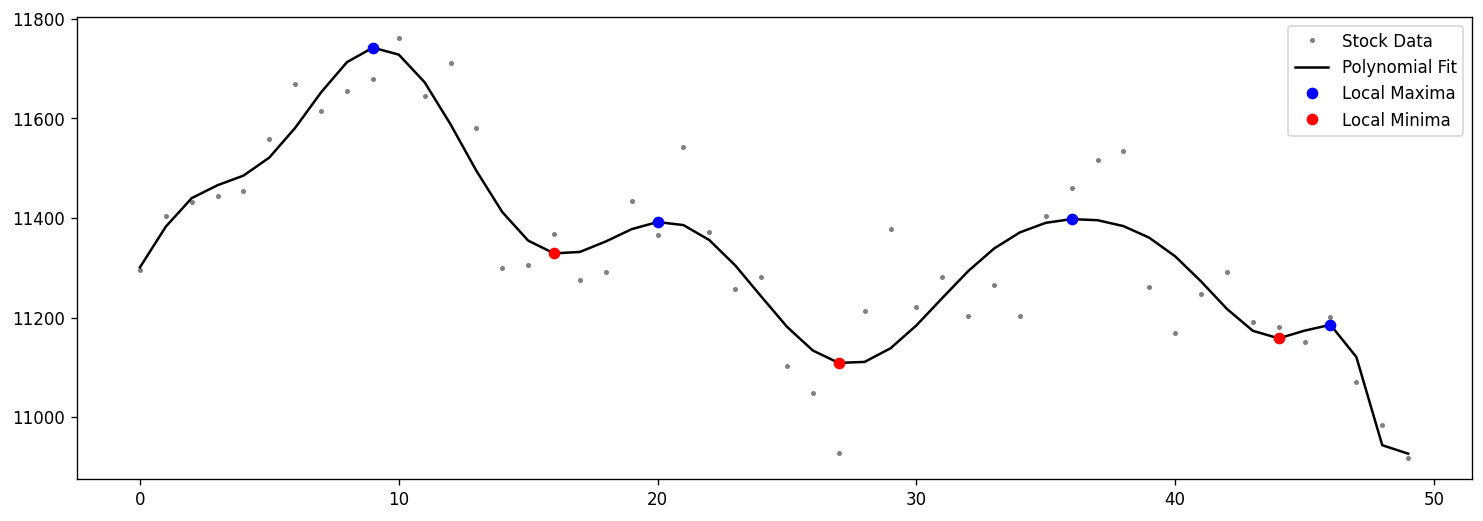

In [13]:
local_maxima_minima_plot(x_data, y_data,x_pol,
                         y_pol, l_min, l_max)